In [5]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, random_split, DataLoader, Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

%matplotlib inline
plt.style.use('fivethirtyeight')


# Arquitetura

In [6]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

# Projeto

In [7]:
# Now you have the "listings.csv" file available in Colab
pd.set_option('display.max_columns', None)

df = pd.read_csv("listings.csv")

In [8]:
target_columns = [
    # Numéricas originais
    "accommodates",      # Number of guests the property can host
    "bathrooms",         # Number of bathrooms available
    "bedrooms",          # Number of bedrooms available
    "beds",              # Number of beds available
    "minimum_nights",    # Minimum nights required for a booking
    "maximum_nights",    # Maximum nights allowed for a booking
    "number_of_reviews", # Total reviews given by past guests
    # Categóricas e de texto
    "room_type",
    "host_is_superhost",
    "amenities",
    # Alvo
    "price"

    #"review_scores_rating"
]


rio_listings = df[target_columns].copy()
# rio_listings.sample(5)

In [ ]:
rio_listings_neighborhood.value_counts()

In [9]:
# Remove commas from the 'price' column (e.g., "$1,200" → "$1200")
stripped_commas = rio_listings['price'].str.replace(',', '')

# Remove dollar signs from the 'price' column (e.g., "$1200" → "1200")
stripped_dollars = stripped_commas.str.replace('$', '')

# Convert the cleaned 'price' column from string to float type
rio_listings['price'] = stripped_dollars.astype('float')

In [10]:
# Remover linhas com valores nulos nas colunas principais
rio_listings.dropna(subset=['price', 'bathrooms', 'bedrooms', 'beds'], inplace=True)

### Robust IQR-based outlier filtering

In [11]:
def _iqr_bounds(series: pd.Series, k: float = 1.5):
    """
    Compute lower/upper bounds for outlier detection using the IQR rule.

    Parameters
    ----------
    series : pd.Series
        Numeric series.
    k : float, default 1.5
        Whisker length multiplier (1.5 = Tukey; 3.0 = more tolerant).

    Returns
    -------
    low : float
        Lower bound (Q1 - k * IQR).
    up : float
        Upper bound (Q3 + k * IQR).
    stats : dict
        Dict with Q1, Q3, IQR.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    up = q3 + k * iqr
    return low, up, {"Q1": q1, "Q3": q3, "IQR": iqr}


def remove_outliers_iqr(
    df: pd.DataFrame,
    columns: list[str],
    k: float = 1.5,
    inclusive: bool = True,
    dropna: bool = True,
):
    """
    Remove rows with outliers per-column using the IQR rule.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str
        Columns to evaluate for outliers (must be numeric or coercible).
    k : float, default 1.5
        Whisker length multiplier (1.5 = standard; 3.0 = lenient).
    inclusive : bool, default True
        If True, keep values exactly on the bounds; otherwise use strict inequality.
    dropna : bool, default True
        If True, drop rows with NaN in the selected columns prior to filtering.

    Returns
    -------
    cleaned : pd.DataFrame
        DataFrame with outlier rows removed.
    info : dict
        Summary with input/output row counts and per-column bounds/statistics.
    """
    data = df.copy()

    # Ensure columns are numeric; non-numeric values become NaN
    for c in columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    # Optionally drop NaNs first to avoid excluding entire rows by comparison
    if dropna:
        data = data.dropna(subset=columns)

    before = len(data)
    bounds = {}
    # Start with all rows valid; refine with each column's mask
    mask = pd.Series(True, index=data.index)

    for c in columns:
        low, up, stats = _iqr_bounds(data[c].dropna(), k=k)
        bounds[c] = {"low": low, "up": up, **stats}

        if inclusive:
            m = (data[c] >= low) & (data[c] <= up)
        else:
            m = (data[c] > low) & (data[c] < up)

        mask &= m

    cleaned = data.loc[mask].copy()
    info = {
        "rows_in": before,
        "rows_out": len(cleaned),
        "rows_removed": before - len(cleaned),
        "k": k,
        "inclusive": inclusive,
        "bounds": bounds,
    }
    return cleaned, info

In [12]:
# Aplicar o mesmo filtro de outliers (IQR) que você já criou.
# A função remove_outliers_iqr já está definida no seu notebook.
numeric_cols_for_iqr = ["accommodates", "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews", "price"]
data_iqr, _ = remove_outliers_iqr(df=rio_listings, columns=numeric_cols_for_iqr)

### --- PASSO 3: Engenharia de Features ---

In [13]:
# 1. Transformação de log no alvo
data_iqr['price_log'] = np.log1p(data_iqr['price'])
data_iqr['price_log']

2        6.685861
4        5.398163
5        5.996452
7        5.991465
8        5.293305
           ...   
42007    6.734592
42008    5.303305
42010    5.262690
42011    4.795791
42012    6.400257
Name: price_log, Length: 23715, dtype: float64

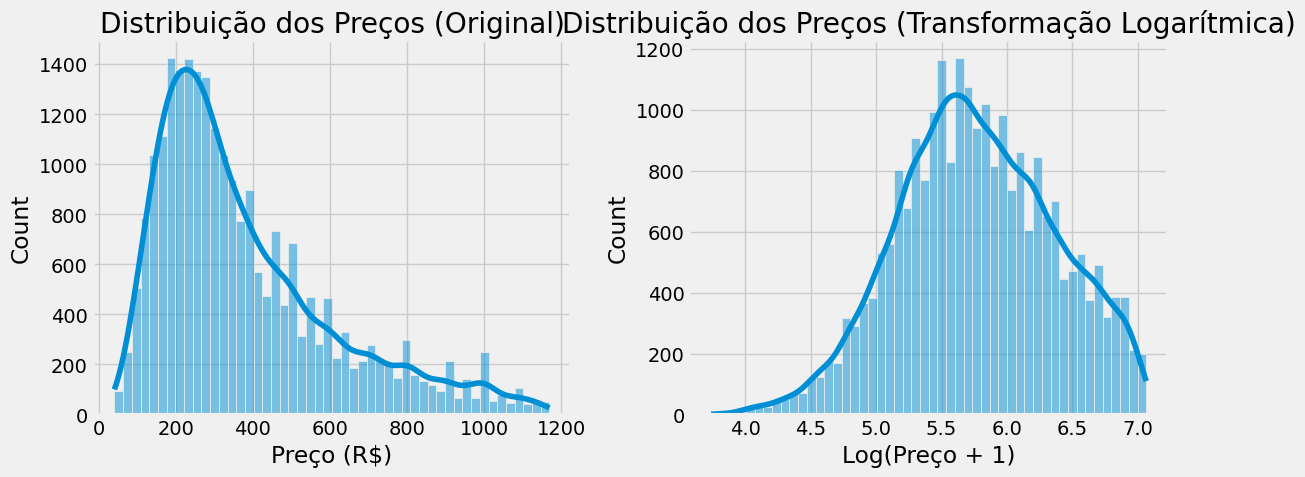

In [14]:
plt.figure(figsize=(12, 5))

# Histograma do preço
plt.subplot(1, 2, 1)
sns.histplot(data_iqr['price'], kde=True, bins=50)
plt.title('Distribuição dos Preços (Original)')
plt.xlabel('Preço (R$)')

# Histograma do log(preço)
plt.subplot(1, 2, 2)
sns.histplot(data_iqr['price_log'], kde=True, bins=50)
plt.title('Distribuição dos Preços (Transformação Logarítmica)')
plt.xlabel('Log(Preço + 1)')

plt.tight_layout()
plt.show()

In [15]:
# 2. Converter host_is_superhost para numérico (0 ou 1) ()
data_iqr['is_superhost'] = (data_iqr['host_is_superhost'] == 't').astype(int)
data_iqr['is_superhost']

2        0
4        0
5        0
7        1
8        0
        ..
42007    0
42008    0
42010    0
42011    0
42012    0
Name: is_superhost, Length: 23715, dtype: int64

In [16]:
# 3. Criar features a partir de 'amenities'
data_iqr['amenities'] = data_iqr['amenities'].fillna('[]') # Garante que não há NaNs
data_iqr['has_wifi'] = data_iqr['amenities'].str.contains('wifi', case=False).astype(int)
data_iqr['has_ac'] = data_iqr['amenities'].str.contains('air conditioning', case=False).astype(int)
data_iqr['has_pool'] = data_iqr['amenities'].str.contains('pool', case=False).astype(int)

In [17]:
# 4. One-Hot Encoding para 'room_type'
room_type_dummies = pd.get_dummies(data_iqr['room_type'], prefix='room_type', drop_first=True) # drop_first para evitar multicolinearidade
data_final = pd.concat([data_iqr, room_type_dummies], axis=1)

In [18]:
data_final

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,room_type,host_is_superhost,amenities,price,price_log,is_superhost,has_wifi,has_ac,has_pool,room_type_Hotel room,room_type_Private room,room_type_Shared room
2,7,2.0,3.0,6.0,5,90,13,Entire home/apt,f,"[""Dedicated workspace"", ""Dishes and silverware...",800.0,6.685861,0,1,1,0,False,False,False
4,4,1.0,1.0,2.0,2,28,28,Entire home/apt,f,"[""Dedicated workspace"", ""Clothing storage: war...",220.0,5.398163,0,1,1,0,False,False,False
5,2,1.0,1.0,1.0,2,730,36,Private room,NaN,"[""Dedicated workspace"", ""Cleaning available du...",401.0,5.996452,0,1,1,0,False,True,False
7,4,2.0,2.0,2.0,3,30,38,Entire home/apt,t,"[""Dedicated workspace"", ""Cleaning available du...",399.0,5.991465,1,1,0,0,False,False,False
8,4,1.0,1.0,2.0,4,90,3,Entire home/apt,f,"[""Dedicated workspace"", ""TV with standard cabl...",198.0,5.293305,0,1,1,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42007,6,2.0,3.0,4.0,1,365,0,Entire home/apt,f,"[""Freezer"", ""Coffee maker"", ""Room-darkening sh...",840.0,6.734592,0,1,1,0,False,False,False
42008,1,1.0,1.0,1.0,1,365,0,Entire home/apt,f,"[""Dedicated workspace"", ""Beach access \u2013 B...",200.0,5.303305,0,1,1,0,False,False,False
42010,2,1.0,1.0,1.0,3,15,0,Entire home/apt,f,"[""Beach access \u2013 Beachfront"", ""Hot water""...",192.0,5.262690,0,1,1,0,False,False,False
42011,2,1.0,1.0,1.0,1,365,0,Entire home/apt,f,"[""Dedicated workspace"", ""Hot water"", ""Safe"", ""...",120.0,4.795791,0,1,1,0,False,False,False


### Matriz de correlação

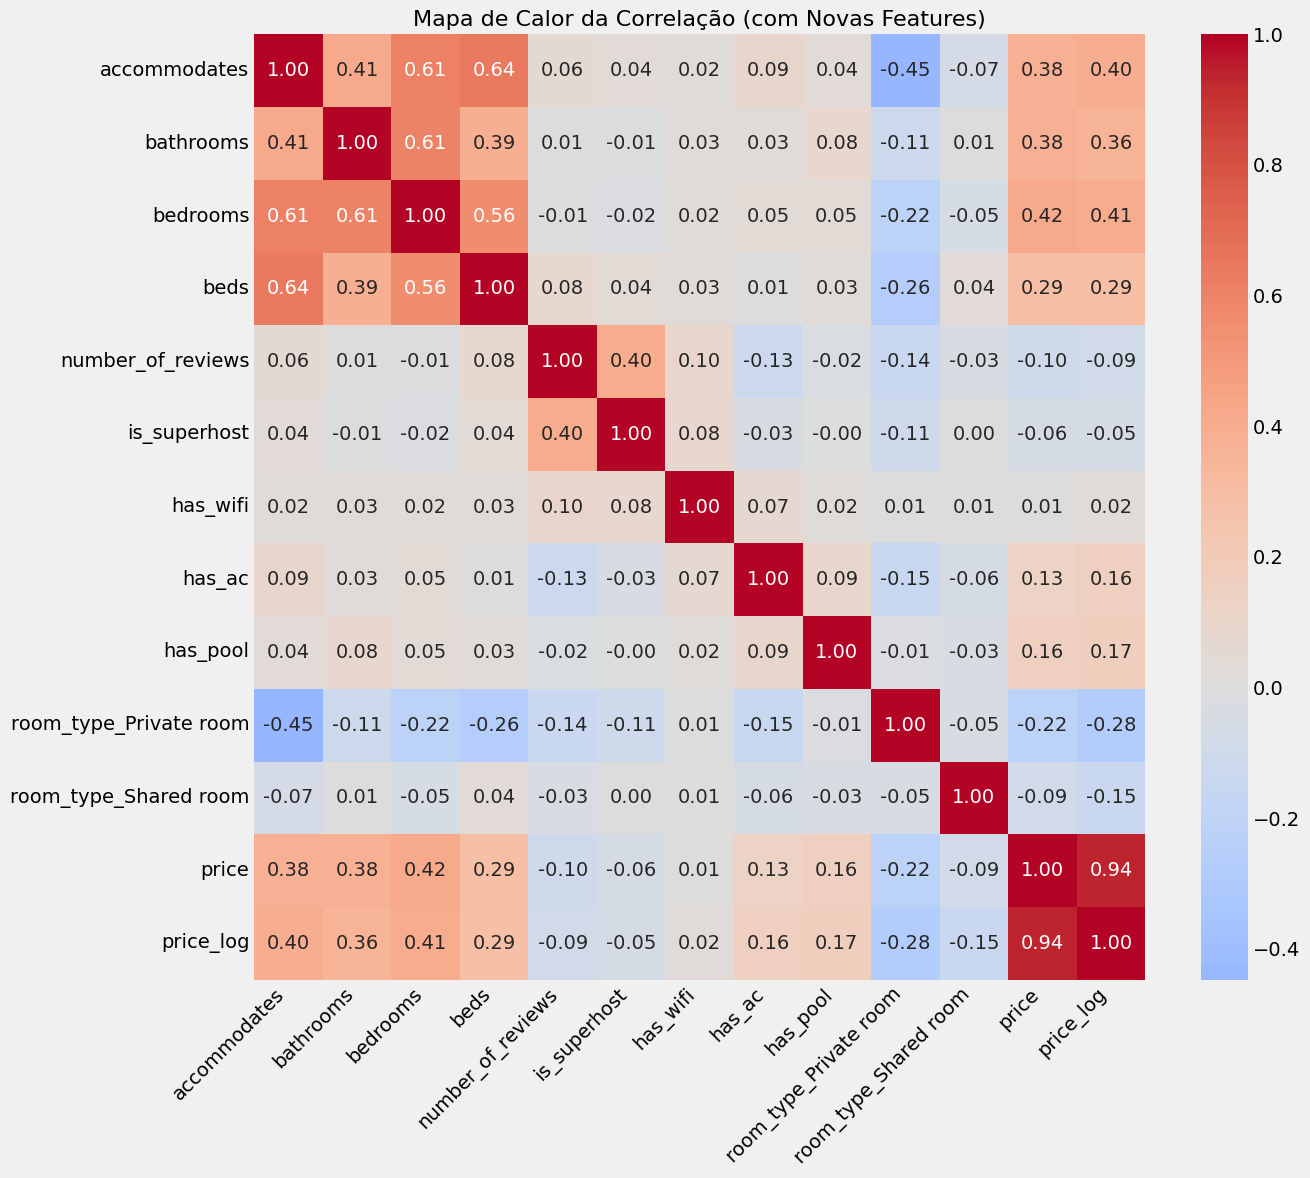

In [19]:
columns_for_corr = [
    # Numéricas originais
    "accommodates", "bathrooms", "bedrooms", "beds", "number_of_reviews",
    # Novas features criadas
    "is_superhost", "has_wifi", "has_ac", "has_pool",
    'room_type_Private room', 'room_type_Shared room', # Colunas do One-Hot Encoding
    # Variáveis Alvo
    "price", "price_log"
]

# Vamos garantir que todas as colunas existem no DataFrame para evitar erros
# (por exemplo, se 'Shared room' não apareceu no seu conjunto de dados limpo)
columns_for_corr = [col for col in columns_for_corr if col in data_final.columns]

# --- 2. Calcular a nova matriz de correlação ---
corr_matrix_expanded = data_final[columns_for_corr].corr(method="pearson")

# --- 3. Gerar o novo gráfico de heatmap ---
# Aumentamos o tamanho do gráfico para acomodar mais features
plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix_expanded,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
)

plt.title("Mapa de Calor da Correlação (com Novas Features)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

### --- PASSO 4: Preparar X e y para o modelo ---

In [20]:
# Selecionar as colunas de features finais
final_feature_cols = [
    "accommodates", "bathrooms", "bedrooms", "beds",
    "minimum_nights", "maximum_nights", "number_of_reviews",
    "is_superhost", "has_wifi", "has_ac", "has_pool"
] + list(room_type_dummies.columns)

final_feature_cols

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'is_superhost',
 'has_wifi',
 'has_ac',
 'has_pool',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room']

In [21]:
# O novo alvo é 'price_log'
final_target_col = 'price_log'

In [22]:
# Converter para NumPy
X_final = data_final[final_feature_cols].to_numpy(dtype=np.float32)
y_final = data_final[final_target_col].to_numpy(dtype=np.float32).reshape(-1, 1)

print(f"Formato final das features (X): {X_final.shape}")
print(f"Formato final do alvo (y): {y_final.shape}")

# A partir daqui, você pode alimentar X_final e y_final no seu pipeline do PyTorch,
# exatamente como fez antes (criando tensores, TensorDataset, random_split, etc.).
# Lembre-se que a dimensão de entrada do seu modelo (D) agora será X_final.shape[1].

Formato final das features (X): (23715, 14)
Formato final do alvo (y): (23715, 1)


In [23]:
X_final

array([[7., 2., 3., ..., 0., 0., 0.],
       [4., 1., 1., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 1., 0.],
       ...,
       [2., 1., 1., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.],
       [5., 1., 2., ..., 0., 0., 0.]], dtype=float32)

# DataFrame de Resultados

In [24]:
# Crie um DataFrame vazio com as colunas que queremos salvar
results_df = pd.DataFrame(columns=[
    'timestamp', 'normalization', 'optimizer', 'lr',
    'epochs', 'batch_size', 'mae', 'rmse', 'r2', 'mape'
])

# Para exibir todas as colunas quando printarmos o DataFrame
pd.set_option('display.max_columns', None)

In [25]:
# Esta função vai encapsular todo o processo. Ela receberá os parâmetros do experimento (tipo de normalização, otimizador, etc.), treinará o modelo e retornará um dicionário com os resultados.

def run_experiment(X_data, y_data, normalization_type, optimizer_type, lr, n_epochs, batch_size):
    """
    Executa um ciclo completo de treinamento e teste com os parâmetros especificados.
    AGORA RECEBE X_data e y_data COMO PARÂMETROS.
    """
    print(f"--- Iniciando Experimento ---")
    print(f"Normalização: {normalization_type}, Otimizador: {optimizer_type}, LR: {lr}, Épocas: {n_epochs}, Batch: {batch_size}")

    # --- 1. Preparação e Divisão dos Dados ---
    torch.manual_seed(13)
    # USA OS PARÂMETROS DA FUNÇÃO DIRETAMENTE
    x_tensor = torch.as_tensor(X_data).float()
    y_tensor = torch.as_tensor(y_data).float()
    dataset = TensorDataset(x_tensor, y_tensor)

    # Divisão em Treino, Validação e Teste
    n_total = len(dataset)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    n_test = n_total - n_train - n_val
    train_data_raw, val_data_raw, test_data_raw = random_split(dataset, [n_train, n_val, n_test])

    # --- 2. Normalização Condicional ---
    train_idx = train_data_raw.indices
    eps = 1e-8

    if normalization_type == 'z_score':
        # Normalização Z-score (como antes)
        mu = x_tensor[train_idx].mean(dim=0)
        std = x_tensor[train_idx].std(dim=0, unbiased=False)
        std = torch.where(std < eps, torch.ones_like(std), std)
        x_tensor_norm = (x_tensor - mu) / std

        y_mu = y_tensor[train_idx].mean(dim=0)
        y_std = y_tensor[train_idx].std(dim=0, unbiased=False)
        y_std = torch.where(y_std < eps, torch.ones_like(y_std), y_std)
        y_tensor_norm = (y_tensor - y_mu) / y_std

    elif normalization_type == 'min_max':
        # Nova opção: Normalização Min-Max
        min_val = x_tensor[train_idx].min(dim=0, keepdim=True).values
        max_val = x_tensor[train_idx].max(dim=0, keepdim=True).values
        range_val = max_val - min_val
        range_val = torch.where(range_val < eps, torch.ones_like(range_val), range_val)
        x_tensor_norm = (x_tensor - min_val) / range_val

        # A normalização do alvo (y) geralmente é melhor com Z-score, mas podemos testar Min-Max também
        y_min_val = y_tensor[train_idx].min(dim=0, keepdim=True).values
        y_max_val = y_tensor[train_idx].max(dim=0, keepdim=True).values
        y_range_val = y_max_val - y_min_val
        y_range_val = torch.where(y_range_val < eps, torch.ones_like(y_range_val), y_range_val)
        y_tensor_norm = (y_tensor - y_min_val) / y_range_val

    # Recriar datasets com dados normalizados
    dataset_norm = TensorDataset(x_tensor_norm, y_tensor_norm)
    train_data = Subset(dataset_norm, train_data_raw.indices)
    val_data = Subset(dataset_norm, val_data_raw.indices)
    test_data = Subset(dataset_norm, test_data_raw.indices)

    # DataLoaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    # --- 3. Configuração e Treinamento do Modelo ---
    torch.manual_seed(42)
    D = x_tensor.shape[1]
    model = nn.Sequential(nn.Linear(D, 1))
    # model = nn.Sequential(
    #     nn.Linear(D, 64),      # Camada de entrada (D features) para 64 neurônios
    #     nn.ReLU(),             # Função de ativação não-linear
    #     nn.Linear(64, 32),     # Camada oculta de 64 para 32 neurônios
    #     nn.ReLU(),             # Outra função de ativação
    #     nn.Linear(32, 1)       # Camada de saída de 32 para 1 (o preço previsto)
    # )
    # model = nn.Sequential(
    #     nn.Linear(D, 64),
    #     nn.ReLU(),
    #     nn.Dropout(0.3),  # Desliga 30% dos neurônios aleatoriamente a cada passagem
    #     nn.Linear(64, 32),
    #     nn.ReLU(),
    #     nn.Dropout(0.3),  # Outra camada de dropout
    #     nn.Linear(32, 1)
    # )

    # Otimizador Condicional
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.MSELoss(reduction='mean')

    arch = Architecture(model, loss_fn, optimizer)
    arch.set_loaders(train_loader, val_loader)
    arch.train(n_epochs=n_epochs)

    # --- 4. Teste e Avaliação ---
    true_values, predictions = [], []
    arch.model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(arch.device)
            y_hat_norm = arch.model(x_batch)
            predictions.append(y_hat_norm.cpu().numpy())
            true_values.append(y_batch.cpu().numpy())

    predictions_norm = np.concatenate(predictions)
    true_values_norm = np.concatenate(true_values)

    # Reverter normalização
    if normalization_type == 'z_score':
        y_pred_log = predictions_norm * y_std.numpy() + y_mu.numpy()
        y_true_log = true_values_norm * y_std.numpy() + y_mu.numpy()
    elif normalization_type == 'min_max':
        y_pred_log = predictions_norm * y_range_val.numpy() + y_min_val.numpy()
        y_true_log = true_values_norm * y_range_val.numpy() + y_min_val.numpy()

    y_pred_real = np.expm1(y_pred_log)
    y_true_real = np.expm1(y_true_log)

    # Calcular métricas
    mae = mean_absolute_error(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2 = r2_score(y_true_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_true_real, y_pred_real)

    # --- 5. Retornar Resultados ---

    # dicionário para guardar os parâmetros de normalização usados
    norm_params = {}
    if normalization_type == 'z_score':
        norm_params['mu'] = mu
        norm_params['std'] = std
        norm_params['y_mu'] = y_mu
        norm_params['y_std'] = y_std
    elif normalization_type == 'min_max':
        norm_params['min_val'] = min_val
        norm_params['max_val'] = max_val
        norm_params['range_val'] = range_val
        norm_params['y_min_val'] = y_min_val
        norm_params['y_max_val'] = y_max_val
        norm_params['y_range_val'] = y_range_val

    results = {
        'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'normalization': normalization_type,
        'optimizer': optimizer_type,
        'lr': lr,
        'epochs': n_epochs,
        'batch_size': batch_size,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'norm_params': norm_params,
        'trained_model': arch
    }

    print("--- Experimento Concluído --- \n")
    return results

# Experimentos

In [26]:
exp1_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='SGD',
    lr=0.001,
    n_epochs=100,
    batch_size=16
)
results_df.loc[len(results_df)] = exp1_results

exp2_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='SGD',
    lr=0.001,
    n_epochs=200,
    batch_size=16
)
results_df.loc[len(results_df)] = exp2_results

exp3_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='Adam',
    lr=0.001,
    n_epochs=100,
    batch_size=16
)
results_df.loc[len(results_df)] = exp3_results

exp4_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='Adam',
    lr=0.001,
    n_epochs=200,
    batch_size=16
)
results_df.loc[len(results_df)] = exp4_results

exp5_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='Adam',
    lr=0.001,
    n_epochs=200,
    batch_size=128
)
results_df.loc[len(results_df)] = exp5_results

exp6_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='Adam',
    lr=0.001,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp6_results

exp7_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='Adam',
    lr=0.001,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp7_results

exp8_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.001,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp8_results

exp9_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.0001,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp9_results

exp10_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.01,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp10_results

exp11_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.01,
    n_epochs=600,
    batch_size=128
)
results_df.loc[len(results_df)] = exp11_results

exp12_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='Adam',
    lr=0.01,
    n_epochs=600,
    batch_size=128
)
results_df.loc[len(results_df)] = exp12_results

exp13_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='SGD',
    lr=0.01,
    n_epochs=600,
    batch_size=128
)
results_df.loc[len(results_df)] = exp13_results

exp14_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='SGD',
    lr=0.01,
    n_epochs=600,
    batch_size=128
)
results_df.loc[len(results_df)] = exp14_results

exp15_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.01,
    n_epochs=200,
    batch_size=16
)
results_df.loc[len(results_df)] = exp15_results

exp16_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='AdamW',
    lr=0.01,
    n_epochs=200,
    batch_size=16
)
results_df.loc[len(results_df)] = exp16_results

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: SGD, LR: 0.001, Épocas: 100, Batch: 16


--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: SGD, LR: 0.001, Épocas: 200, Batch: 16
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: Adam, LR: 0.001, Épocas: 100, Batch: 16
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: Adam, LR: 0.001, Épocas: 200, Batch: 16
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: Adam, LR: 0.001, Épocas: 200, Batch: 128
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: Adam, LR: 0.001, Épocas: 400, Batch: 128
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: min_max, Otimizador: Adam, LR: 0.001, Épocas: 400, Batch: 128
--- Experimento Concluído --- 

--- Iniciando Experimento ---
Normalização: min_max, Otimizador: SGD, LR: 0.001, Épocas: 400, Batch: 128
--- Experimento Concluído --- 

--- Ini

In [27]:
exp17_results = run_experiment(
    X_final,
    y_final,
    normalization_type='z_score',
    optimizer_type='AdamW',
    lr=0.001,
    n_epochs=200,
    batch_size=16
)
results_df.loc[len(results_df)] = exp17_results

# --- Visualizar e Salvar os resultados ---
display(results_df)
results_df.to_csv('resultados_experimentos_sequencial_1n.csv', index=False)

--- Iniciando Experimento ---
Normalização: z_score, Otimizador: AdamW, LR: 0.001, Épocas: 200, Batch: 16
--- Experimento Concluído --- 



,timestamp,normalization,optimizer,lr,epochs,batch_size,mae,rmse,r2,mape
0,2025-09-24 14:41:33,z_score,SGD,0.0010,100,16,140.850266,202.215729,0.244056,0.435443
1,2025-09-24 14:43:27,z_score,SGD,0.0010,200,16,140.740158,202.403442,0.242652,0.433619
2,2025-09-24 14:44:36,z_score,Adam,0.0010,100,16,141.029022,202.245209,0.243835,0.436384
3,2025-09-24 14:46:55,z_score,Adam,0.0010,200,16,140.720154,202.741486,0.240120,0.431483
4,2025-09-24 14:47:32,z_score,Adam,0.0010,200,128,140.828812,202.225266,0.243984,0.435351
5,2025-09-24 14:48:51,z_score,Adam,0.0010,400,128,140.729111,202.475266,0.242114,0.433539
6,2025-09-24 14:50:05,min_max,Adam,0.0010,400,128,140.766693,202.310349,0.243348,0.434805
7,2025-09-24 14:51:15,min_max,SGD,0.0010,400,128,140.877701,202.793976,0.239726,0.434097
8,2025-09-24 14:52:26,min_max,SGD,0.0001,400,128,152.543991,217.910477,0.122159,0.477996
9,2025-09-24 14:53:34,min_max,SGD,0.0100,400,128,140.776581,202.230515,0.243945,0.435113


In [28]:
exp9_results = run_experiment(
    X_final,
    y_final,
    normalization_type='min_max',
    optimizer_type='SGD',
    lr=0.0001,
    n_epochs=400,
    batch_size=128
)
results_df.loc[len(results_df)] = exp9_results

--- Iniciando Experimento ---
Normalização: min_max, Otimizador: SGD, LR: 0.0001, Épocas: 400, Batch: 128
--- Experimento Concluído --- 



In [29]:
results_df

,timestamp,normalization,optimizer,lr,epochs,batch_size,mae,rmse,r2,mape
0,2025-09-24 14:41:33,z_score,SGD,0.0010,100,16,140.850266,202.215729,0.244056,0.435443
1,2025-09-24 14:43:27,z_score,SGD,0.0010,200,16,140.740158,202.403442,0.242652,0.433619
2,2025-09-24 14:44:36,z_score,Adam,0.0010,100,16,141.029022,202.245209,0.243835,0.436384
3,2025-09-24 14:46:55,z_score,Adam,0.0010,200,16,140.720154,202.741486,0.240120,0.431483
4,2025-09-24 14:47:32,z_score,Adam,0.0010,200,128,140.828812,202.225266,0.243984,0.435351
5,2025-09-24 14:48:51,z_score,Adam,0.0010,400,128,140.729111,202.475266,0.242114,0.433539
6,2025-09-24 14:50:05,min_max,Adam,0.0010,400,128,140.766693,202.310349,0.243348,0.434805
7,2025-09-24 14:51:15,min_max,SGD,0.0010,400,128,140.877701,202.793976,0.239726,0.434097
8,2025-09-24 14:52:26,min_max,SGD,0.0001,400,128,152.543991,217.910477,0.122159,0.477996
9,2025-09-24 14:53:34,min_max,SGD,0.0100,400,128,140.776581,202.230515,0.243945,0.435113


In [30]:
# print("\nLimpando o DataFrame 'results_df' na memória...")

# results_df = pd.DataFrame(columns=[
#     'timestamp', 'normalization', 'optimizer', 'lr',
#     'epochs', 'batch_size', 'mae', 'rmse', 'r2', 'mape'
# ])

# print("DataFrame limpo e pronto para novos experimentos.")
# display(results_df)

In [31]:
import numpy as np
import torch

# --------------------------------------------------------------------------
# 1. Defina o novo exemplo com TODAS as 14 features na ordem correta
# --------------------------------------------------------------------------
X_new = np.array([[
    # --- Features Numéricas/Básicas (as 11 primeiras) ---
    2.0,  # accommodates: 2 pessoas
    1.0,  # bathrooms: 1 banheiro
    1.0,  # bedrooms: 1 quarto
    1.0,  # beds: 1 cama
    3.0,  # minimum_nights: 3 noites
    90.0, # maximum_nights: 90 noites
    55.0, # number_of_reviews: 55 avaliações
    0.0,  # is_superhost: Não (0.0 para False)
    1.0,  # has_wifi: Sim (1.0 para True)
    1.0,  # has_ac: Sim (1.0 para True)
    0.0,  # has_pool: Não (0.0 para False)

    # --- Features do One-Hot Encoding (as 3 últimas) ---
    0.0,  # room_type_Hotel room: Não
    1.0,  # room_type_Private room: Sim
    0.0   # room_type_Shared room: Não
]], dtype=np.float32)

# Verificação rápida da forma (deve ser (1, 14))
print(f"Shape do novo X_new: {X_new.shape}")

# --------------------------------------------------------------------------
# 2. O restante do seu código de predição agora funcionará
#    (assumindo que 'exp_results' contém os resultados do seu experimento)
# --------------------------------------------------------------------------
# Extraia os objetos necessários dos resultados do experimento
normalization_type = exp9_results['normalization']
params = exp9_results['norm_params']
trained_arch = exp9_results['trained_model']

X_new_t = torch.as_tensor(X_new)

# Aplicar a MESMA normalização de features do treino
if normalization_type == 'z_score':
    X_new_norm = (X_new_t - params['mu']) / params['std']
elif normalization_type == 'min_max':
    X_new_norm = (X_new_t - params['min_val']) / params['range_val']

# Prever com o modelo treinado
X_new_norm = X_new_norm.to(trained_arch.device)
y_pred_norm = trained_arch.model(X_new_norm)
y_pred_norm = y_pred_norm.cpu().detach().numpy()

# Reverter a normalização do alvo para a unidade original
if normalization_type == 'z_score':
    y_pred_log = y_pred_norm * params['y_std'].numpy() + params['y_mu'].numpy()
elif normalization_type == 'min_max':
    y_pred_log = y_pred_norm * params['y_range_val'].numpy() + params['y_min_val'].numpy()

# Reverter a transformação logarítmica final (expm1)
y_pred_real = np.expm1(y_pred_log)
y_pred_real_value = float(y_pred_real.squeeze())

print(f"\nTipo de Normalização Usada: {normalization_type}")
print(f"Preço Previsto: R$ {y_pred_real_value:.2f}")

Shape do novo X_new: (1, 14)

Tipo de Normalização Usada: min_max
Preço Previsto: R$ 166.30


# LazyPredict

In [32]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Dados originais (como antes)
X_lazy = X_final
y_lazy_log = data_final['price_log'].to_numpy()

# Divisão principal 80/20
X_train_full, X_test, y_train_full, y_test_log = train_test_split(
    X_lazy, y_lazy_log, test_size=0.2, random_state=42
)

# --- NOVO PASSO: Criar uma amostra menor para o LazyPredict ---
# Vamos usar apenas 30% dos dados de treino para o teste rápido
_, X_train_sample, _, y_train_sample = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42
)


print(f"Formato dos dados de treino COMPLETOS: X_train_full={X_train_full.shape}")
print(f"Formato dos dados de treino para AMOSTRA: X_train_sample={X_train_sample.shape}")
print(f"Formato dos dados de teste: X_test={X_test.shape}, y_test_log={y_test_log.shape}")

Formato dos dados de treino COMPLETOS: X_train_full=(18972, 14)
Formato dos dados de treino para AMOSTRA: X_train_sample=(5692, 14)
Formato dos dados de teste: X_test=(4743, 14), y_test_log=(4743,)


In [33]:
!pip install lazypredict

In [34]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Usando a amostra menor para o fit
models, predictionas_log = reg.fit(X_train_sample, X_test, y_train_sample, y_test_log)

print("--- Desempenho dos Modelos (rodando em uma amostra de 30% dos dados) ---")
display(models)

  0%|          | 0/42 [00:00<?, ?it/s]

--- Desempenho dos Modelos (rodando em uma amostra de 30% dos dados) ---


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.35,0.35,0.49,0.53
LGBMRegressor,0.34,0.34,0.49,0.13
HistGradientBoostingRegressor,0.34,0.34,0.49,-1.88
NuSVR,0.33,0.33,0.49,2.16
SVR,0.32,0.32,0.50,2.66
ElasticNetCV,0.31,0.31,0.50,0.18
LassoCV,0.31,0.31,0.50,0.17
RidgeCV,0.31,0.31,0.50,0.04
Ridge,0.31,0.31,0.50,0.04


# PyCaret

In [35]:
!pip install pycaret[models]

  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 MB 1.9 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.0 MB/s eta 0:00:00a 0:00:01
Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1 requires sympy==1.13.1, but you have sympy 1.13.3 which is incompatible.


In [36]:
# 1. Selecione apenas as colunas finais de features e o alvo (price_log)
#    do seu DataFrame já processado.
final_cols_for_pycaret = final_feature_cols + [final_target_col]
pycaret_df = data_final[final_cols_for_pycaret].copy()

# 2. Verifique as primeiras linhas do novo DataFrame
print("DataFrame pronto para o PyCaret:")
display(pycaret_df.head())

DataFrame pronto para o PyCaret:


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,is_superhost,has_wifi,has_ac,has_pool,room_type_Hotel room,room_type_Private room,room_type_Shared room,price_log
2,7,2.00,3.00,6.00,5,90,13,0,1,1,0,False,False,False,6.69
4,4,1.00,1.00,2.00,2,28,28,0,1,1,0,False,False,False,5.40
5,2,1.00,1.00,1.00,2,730,36,0,1,1,0,False,True,False,6.00
7,4,2.00,2.00,2.00,3,30,38,1,1,0,0,False,False,False,5.99
8,4,1.00,1.00,2.00,4,90,3,0,1,1,0,False,False,False,5.29


In [37]:
import pandas as pd
from pycaret.regression import *

# Supondo que 'X_train_full' é um DataFrame e 'y_train_full_log' é uma Series
# Vamos juntá-los para o PyCaret
# Certifique-se de que os índices estão alinhados
data_para_pycaret = X_train_full.copy()
data_para_pycaret['log_price'] = y_train_full_log # Adicione a coluna alvo

print("Formato dos dados para o PyCaret:")
print(data_para_pycaret.shape)
display(data_para_pycaret.head())

NameError: name 'y_train_full_log' is not defined